Will create 10000 random circuits and fidn sparsity and entropy for each as well as simulation time on MPS.

In [1]:
from qtn_sim import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [74]:
numberOfQubits = 20
numberOfCircuits = 10000
maxCircuitDepth = 100
config = str("_depth" + str(maxCircuitDepth) + "_num" + str(numberOfCircuits) + "_q" + str(numberOfQubits))
# config = "longDistance" + str("_depth" + str(maxCircuitDepth) + "_num" + str(numberOfCircuits) + "_q" + str(numberOfQubits))
filePath = "circuits" + config + ".json"

In [30]:
circuits = createCircuits(numberOfCircuits=numberOfCircuits, 
                          numberOfQubits=numberOfQubits, 
                          maxCircuitDepth=maxCircuitDepth, 
                          withNonAdjacent=True, 
                          filePath=filePath)

In [31]:
circuitsRead = readCircuits(filePath=filePath)

Now lets get the metrics

In [32]:
def getMPSEntropy(mps):
    total_entropy = 0
    for bond in range(len(mps) - 1):
        tensor = mps[bond]
        shape = tensor.shape
        matrix = tensor.reshape(shape[0] * shape[1], -1)
        _, S, _ = np.linalg.svd(matrix, full_matrices=False)
        probabilities = S**2
        probabilities /= np.sum(probabilities)
        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-12))
        total_entropy += entropy
    return total_entropy

def getSparsity(statevector):
    return np.count_nonzero(statevector)/len(statevector)

In [33]:
entropy = []
sparsity = []

for circuit in circuitsRead:
    bond_dimension = 4
    MPS = QuantumMPS(numberOfQubits, bond_dimension)
    MPS.applyCircuit(circuit=circuit)
    entropy.append(getMPSEntropy(MPS.tensors))

In [34]:
ed = pd.DataFrame({'entropy' : entropy})
ed.to_csv('entropy'+config+'.csv')

In [35]:
for circuit in circuitsRead:
    bond_dimension = 4
    MPS = QuantumMPS(numberOfQubits, bond_dimension)
    MPS.applyCircuit(circuit=circuit)
    sparsity.append(getSparsity(MPS.get_state_vector()))

In [36]:
sd = pd.DataFrame({'sparsity' : sparsity})
sd.to_csv('sparsity'+config+'.csv')

Will get time and memory

In [37]:
import tracemalloc, time

times = []
mems = []
for circuit in circuitsRead:
    bond_dimension = 4
    q = QuantumMPS(numberOfQubits, bond_dimension)
    
    circuitApplied = circuit

    start = time.perf_counter_ns()
    tracemalloc.start()

    q.applyCircuit(circuitApplied)

    mem = tracemalloc.get_traced_memory()

    tracemalloc.stop()

    end = time.perf_counter_ns()
    timeIt = end - start

    times.append(timeIt)
    mems.append(mem[1])

In [38]:
pd.DataFrame({'entropy' : entropy, 'sparsity' : sparsity, 'time' : times, 'memory' : mems}).to_csv('allData'+config+'.csv')

In [64]:
data = pd.read_csv('data2/allData'+config+'.csv')

Need to clean data, outliers.

In [65]:
def is_outlier(row):
    if row['memory'] > 500000:
        return True 
    return False
df_cleaned = data[~data.apply(is_outlier, axis=1)]

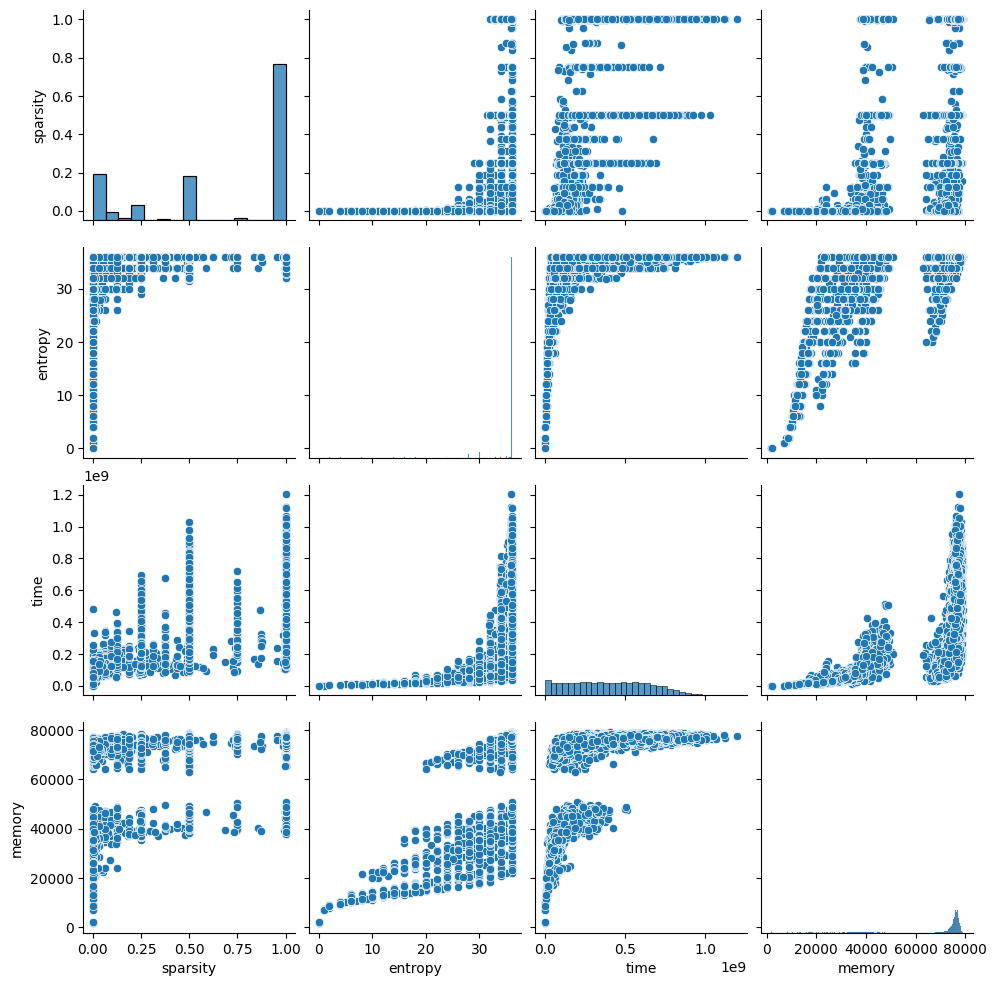

In [72]:
import seaborn as sns

sns.pairplot(df_cleaned[['sparsity', 'entropy', 'time', 'memory']])

plt.show()

        sparsity    entropy       time   memory
0   3.906250e-03  27.000000   61829800  6072399
1   3.814697e-06   9.000000    7757700    12016
2   9.536743e-07   3.000000    4176800     8976
3   6.250000e-02  30.000000   53028700    69311
4   3.051758e-05  11.000000   10589000    12903
..           ...        ...        ...      ...
5   2.500000e-01  35.997141  161917900    64303
6   1.000000e+00  35.999822  748227200    76855
7   5.000000e-01  35.999988  416350800    77055
8   7.500000e-01  35.979503  311805700    74431
9   1.000000e+00  36.000000  566650800    77559

[10010 rows x 4 columns]


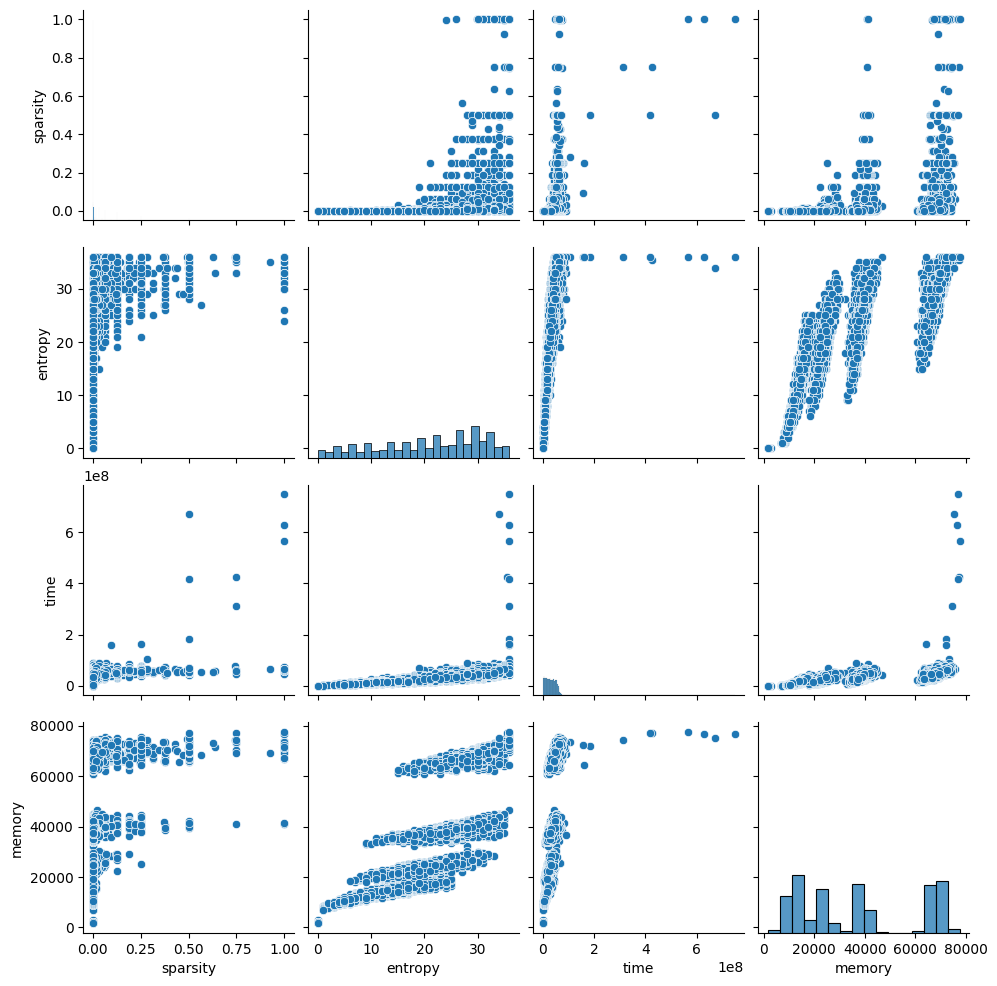

In [ ]:
# Combined:


df1 = pd.read_csv('Data/allData'+config+'.csv')
df2 = pd.read_csv('data2/allData'+'longDistance'+config+'.csv').head(1000)

combined_df = pd.concat([df1[['sparsity', 'entropy', 'time', 'memory']], df2[['sparsity', 'entropy', 'time', 'memory']]])

print(combined_df)

def is_outlier(row):
    if row['memory'] > 500000:
        return True 
    return False
combined_df_clean = combined_df[~combined_df.apply(is_outlier, axis=1)]

sns.pairplot(combined_df_clean[['sparsity', 'entropy', 'time', 'memory']])
plt.show()